# RAWG Game Success Prediction - Model Training

Este notebook implementa un pipeline completo de machine learning para predecir el éxito de videojuegos usando únicamente información disponible en la fase de diseño.

**Contexto de negocio**: Los estudios de videojuegos necesitan evaluar el potencial de éxito de sus proyectos antes del lanzamiento para optimizar recursos y tomar decisiones estratégicas.

**Objetivo**: Comparar 4 algoritmos (Linear Regression, Random Forest, XGBoost, Red Neuronal) para predecir success_score.
**Dataset**: 76,272 juegos filtrados por calidad con 4 features de diseño y target continuo (0-1).
**Métricas**: RMSE, MAE, R², MAPE para evaluación integral del rendimiento.
**Metodología**: Train/Validation/Test split + Hyperparameter tuning + Análisis interpretable.

## 1. Imports y configuración inicial

Importamos todas las librerías necesarias para el pipeline de machine learning, incluyendo TensorFlow para implementar una red neuronal optimizada con callbacks avanzados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import os
from scipy.stats import randint, uniform
from scipy import stats

# TensorFlow para red neuronal optimizada
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Configuración de visualización
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")
np.random.seed(42)

print("Librerías importadas correctamente")

2025-08-06 09:24:25.877266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754472266.051910      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754472266.102432      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Librerías importadas correctamente


## 2. Carga y exploración del dataset

Cargamos el dataset final procesado en el EDA que contiene únicamente las 4 features de diseño más predictivas y el target success_score. Este dataset ha sido filtrado por calidad (rating > 0, added > 0) y rango temporal (2010-2024) para asegurar datos confiables. La feature esrb_rating_id fue eliminada debido a que el 77.5% de los registros tenían valores faltantes.

**Features de entrada**: n_genres, n_platforms, n_tags, release_year (4 variables de diseño)
**Target**: success_score (0-1) - métrica compuesta de rating, popularidad y engagement
**Tamaño esperado**: ~76k juegos tras filtros de calidad
**Nota**: esrb_rating_id eliminada por 77.5% de valores faltantes

In [2]:
# Cargar dataset desde archivo Parquet (más eficiente)
# Intentar múltiples rutas posibles para mayor flexibilidad
possible_paths = [
    "/kaggle/input/training-rawg/training_dataset_final.parquet",
    "../Data/training_dataset_final.parquet",
    "./training_dataset_final.parquet"
]

df = None
for data_path in possible_paths:
    try:
        if os.path.exists(data_path):
            df = pd.read_parquet(data_path)
            print(f"Dataset cargado desde: {data_path}")
            break
    except Exception as e:
        print(f"Error cargando desde {data_path}: {e}")
        continue

if df is None:
    raise FileNotFoundError("No se pudo cargar el dataset desde ninguna ruta disponible")

print(f"Dataset cargado: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print(f"Tipos de datos:")
print(df.dtypes)

Dataset cargado desde: /kaggle/input/training-rawg/training_dataset_final.parquet
Dataset cargado: (76272, 7)
Columnas: ['id_game', 'name', 'n_genres', 'n_platforms', 'n_tags', 'release_year', 'success_score']
Tipos de datos:
id_game            int64
name              object
n_genres           int64
n_platforms        int64
n_tags             int64
release_year     float64
success_score    float64
dtype: object


In [3]:
# Exploración básica del dataset
print("Primeras 5 filas:")
display(df.head())

print("\nEstadísticas descriptivas:")
display(df.describe())

print("\nValores nulos:")
print(df.isnull().sum())

Primeras 5 filas:


,id_game,name,n_genres,n_platforms,n_tags,release_year,success_score
0,4200,Portal 2,2,6,25,2011.0,1.0373
1,3328,The Witcher 3: Wild Hunt,2,7,20,2015.0,1.0247
2,3498,Grand Theft Auto V,1,7,19,2013.0,1.0237
3,58175,God of War (2018),1,2,27,2018.0,1.0155
4,4062,BioShock Infinite,2,7,21,2013.0,1.0091



Estadísticas descriptivas:


,id_game,n_genres,n_platforms,n_tags,release_year,success_score
count,7.627200e+04,76272.000000,76272.000000,76272.000000,76272.000000,76272.000000
mean,3.326135e+05,2.103970,1.722834,8.903110,2017.806482,0.263999
std,3.407556e+05,1.328006,1.210024,7.471555,3.616108,0.157904
min,1.000000e+00,0.000000,0.000000,0.000000,2010.000000,0.065100
25%,2.391250e+04,1.000000,1.000000,3.000000,2016.000000,0.165100
50%,2.325910e+05,2.000000,1.000000,7.000000,2018.000000,0.205000
75%,6.073620e+05,3.000000,2.000000,14.000000,2021.000000,0.307800
max,1.006738e+06,12.000000,22.000000,70.000000,2024.000000,1.037300



Valores nulos:
id_game          0
name             0
n_genres         0
n_platforms      0
n_tags           0
release_year     0
success_score    0
dtype: int64


### Análisis de la distribución del target

Verificamos la distribución del success_score para entender el problema de regresión.

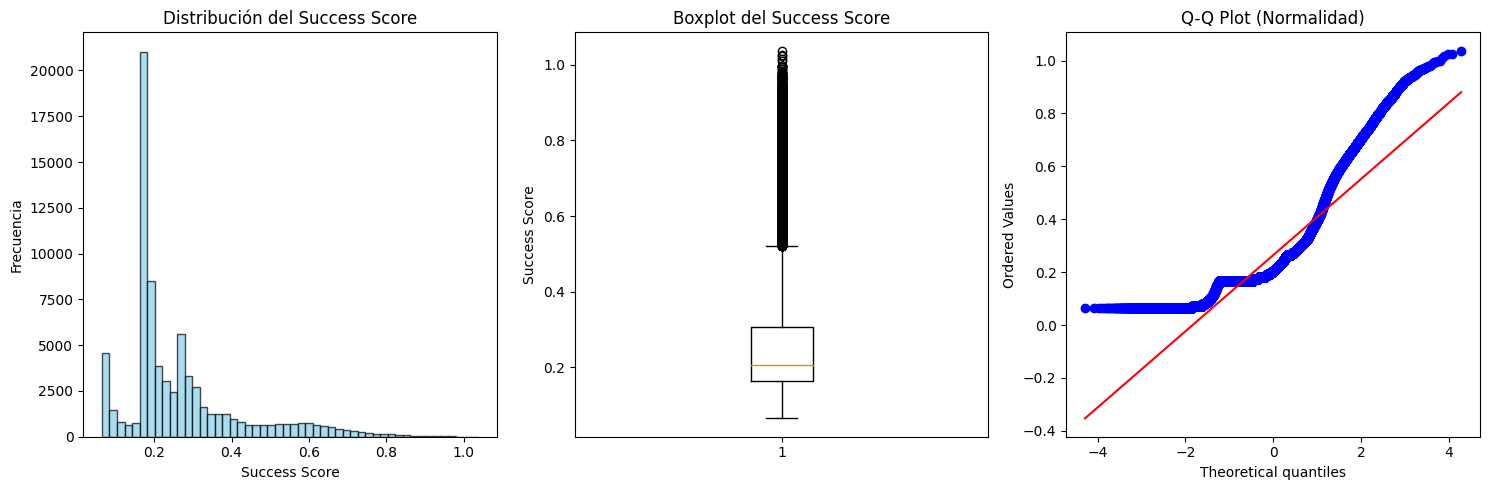

Success Score - Min: 0.0651, Max: 1.0373
Success Score - Media: 0.2640, Std: 0.1579


In [4]:
# Visualización de la distribución del target
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histograma
axes[0].hist(df['success_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución del Success Score')
axes[0].set_xlabel('Success Score')
axes[0].set_ylabel('Frecuencia')

# Boxplot
axes[1].boxplot(df['success_score'])
axes[1].set_title('Boxplot del Success Score')
axes[1].set_ylabel('Success Score')

# Q-Q plot para normalidad
stats.probplot(df['success_score'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normalidad)')

plt.tight_layout()
plt.show()

print(f"Success Score - Min: {df['success_score'].min():.4f}, Max: {df['success_score'].max():.4f}")
print(f"Success Score - Media: {df['success_score'].mean():.4f}, Std: {df['success_score'].std():.4f}")

## 3. Preparación de datos

Separamos features y target, dividimos en conjuntos de entrenamiento/validación/test y aplicamos escalado cuando sea necesario.

In [5]:
# Separar features y target
feature_columns = ['n_genres', 'n_platforms', 'n_tags', 'release_year']
X = df[feature_columns].copy()
y = df['success_score'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Verificar que no hay valores nulos en features
print(f"Valores nulos en features: {X.isnull().sum().sum()}")

Features shape: (76272, 4)
Target shape: (76272,)
Valores nulos en features: 0


In [6]:
# División en train/validation/test (70/20/10)
# Nota: No usamos stratify porque es un problema de regresión, no clasificación
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, random_state=42)  # 0.222 * 0.9 = 0.2

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

Train set: 53405 samples (70.0%)
Validation set: 15239 samples (20.0%)
Test set: 7628 samples (10.0%)


In [7]:
# Escalado de features (necesario para Red Neuronal)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Escalado aplicado a todas las particiones")

Escalado aplicado a todas las particiones


## 4. Definición de métricas de evaluación

Definimos funciones para calcular todas las métricas de evaluación de forma consistente.

In [8]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calcula todas las métricas de evaluación para regresión"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    # Evitamos división por cero añadiendo epsilon
    epsilon = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    
    metrics = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }
    
    return metrics

def print_metrics(metrics):
    """Imprime métricas de forma formateada"""
    print(f"Modelo: {metrics['Model']}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"MAE: {metrics['MAE']:.6f}")
    print(f"R²: {metrics['R²']:.6f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print("-" * 40)

## 5. Modelo Baseline: Linear Regression

Comenzamos con un modelo simple como baseline para establecer una referencia de rendimiento.

In [9]:
# Entrenar Linear Regression
print("Entrenando Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

# Métricas
lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, "Linear Regression (Train)")
lr_val_metrics = calculate_metrics(y_val, y_val_pred_lr, "Linear Regression (Validation)")

print_metrics(lr_train_metrics)
print_metrics(lr_val_metrics)

Entrenando Linear Regression...
Modelo: Linear Regression (Train)
RMSE: 0.139086
MAE: 0.102764
R²: 0.224672
MAPE: 50.25%
----------------------------------------
Modelo: Linear Regression (Validation)
RMSE: 0.138913
MAE: 0.102429
R²: 0.230958
MAPE: 49.76%
----------------------------------------


Coeficientes de Linear Regression:


,Feature,Coefficient,Abs_Coefficient
1,n_platforms,0.049322,0.049322
0,n_genres,0.011451,0.011451
3,release_year,-0.007258,0.007258
2,n_tags,0.002692,0.002692


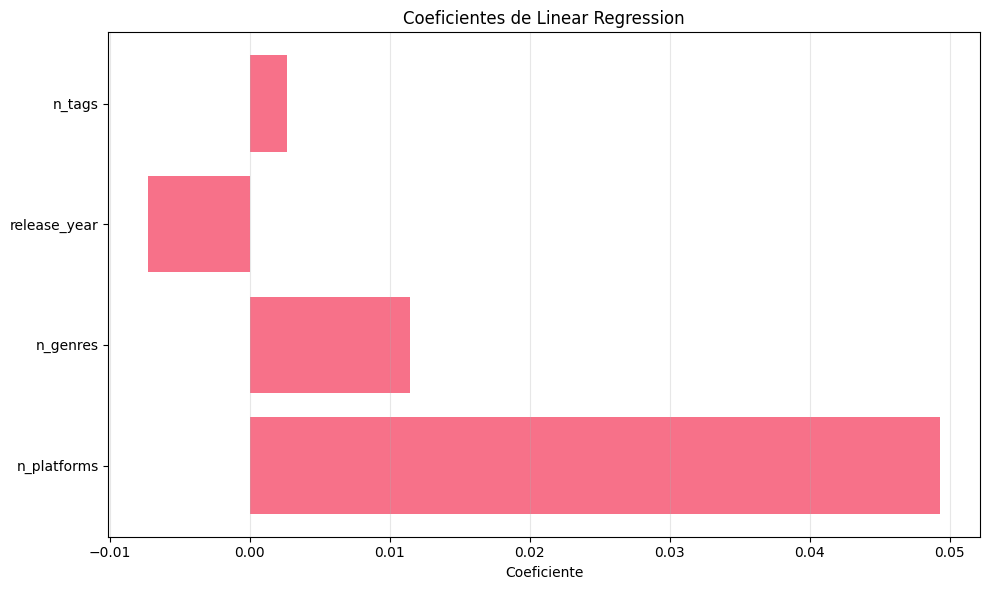

In [10]:
# Análisis de coeficientes de Linear Regression
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Coeficientes de Linear Regression:")
display(coefficients)

# Visualización de coeficientes
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.title('Coeficientes de Linear Regression')
plt.xlabel('Coeficiente')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Random Forest con Hyperparameter Tuning

Entrenamos Random Forest con búsqueda aleatoria de hiperparámetros para optimizar el rendimiento.

In [11]:
# Definir espacio de búsqueda para Random Forest
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

print("Iniciando búsqueda de hiperparámetros para Random Forest...")

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"Mejores parámetros RF: {rf_random.best_params_}")
print(f"Mejor score CV: {-rf_random.best_score_:.6f}")

Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros RF: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 77}
Mejor score CV: 0.017660


In [12]:
# Entrenar modelo final con mejores parámetros
rf_model = rf_random.best_estimator_

# Predicciones
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Métricas
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, "Random Forest (Train)")
rf_val_metrics = calculate_metrics(y_val, y_val_pred_rf, "Random Forest (Validation)")

print_metrics(rf_train_metrics)
print_metrics(rf_val_metrics)

Modelo: Random Forest (Train)
RMSE: 0.128908
MAE: 0.093958
R²: 0.333989
MAPE: 46.24%
----------------------------------------
Modelo: Random Forest (Validation)
RMSE: 0.133096
MAE: 0.096419
R²: 0.294012
MAPE: 46.70%
----------------------------------------


Feature Importance - Random Forest:


,Feature,Importance
1,n_platforms,0.540621
2,n_tags,0.174035
3,release_year,0.155673
0,n_genres,0.129671


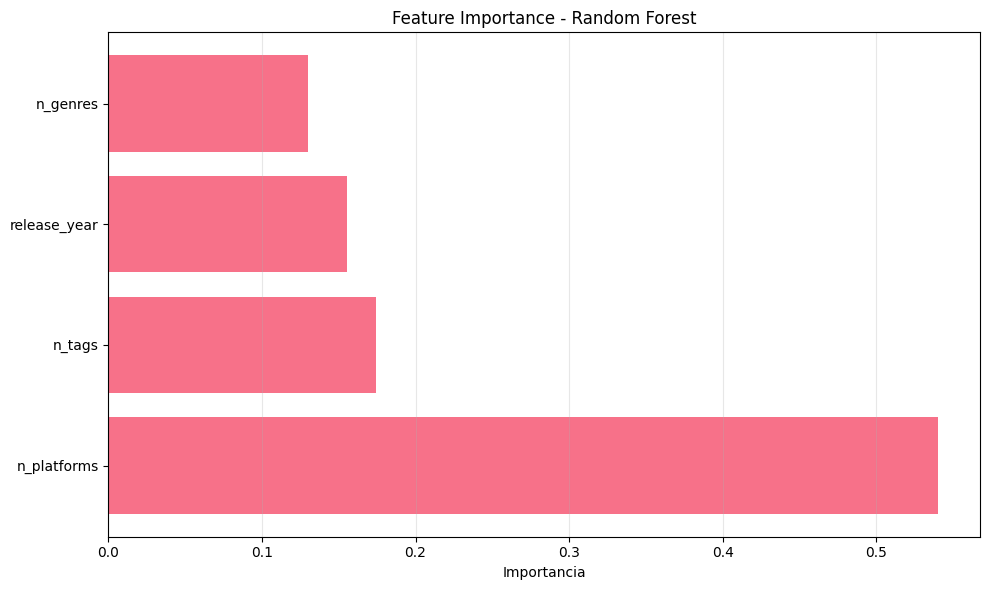

In [13]:
# Feature importance de Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance - Random Forest:")
display(feature_importance_rf)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importancia')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. XGBoost con Hyperparameter Tuning

Entrenamos XGBoost, conocido por su excelente rendimiento en problemas de regresión con datos tabulares.

In [14]:
# Definir espacio de búsqueda para XGBoost
xgb_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

print("Iniciando búsqueda de hiperparámetros para XGBoost...")

# RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, verbosity=0, n_jobs=1),
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train, y_train)

print(f"Mejores parámetros XGB: {xgb_random.best_params_}")
print(f"Mejor score CV: {-xgb_random.best_score_:.6f}")

Iniciando búsqueda de hiperparámetros para XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros XGB: {'colsample_bytree': 0.9627313766183017, 'learning_rate': 0.09163967481539059, 'max_depth': 5, 'n_estimators': 170, 'reg_alpha': 0.8180147659224931, 'reg_lambda': 0.8607305832563434, 'subsample': 0.6027808522124762}
Mejor score CV: 0.017665


In [15]:
# Entrenar modelo final con mejores parámetros
xgb_model = xgb_random.best_estimator_

# Predicciones
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# Métricas
xgb_train_metrics = calculate_metrics(y_train, y_train_pred_xgb, "XGBoost (Train)")
xgb_val_metrics = calculate_metrics(y_val, y_val_pred_xgb, "XGBoost (Validation)")

print_metrics(xgb_train_metrics)
print_metrics(xgb_val_metrics)

Modelo: XGBoost (Train)
RMSE: 0.130746
MAE: 0.095052
R²: 0.314865
MAPE: 46.69%
----------------------------------------
Modelo: XGBoost (Validation)
RMSE: 0.133282
MAE: 0.096459
R²: 0.292035
MAPE: 46.75%
----------------------------------------


Feature Importance - XGBoost:


,Feature,Importance
1,n_platforms,0.612192
0,n_genres,0.144198
2,n_tags,0.132321
3,release_year,0.111289


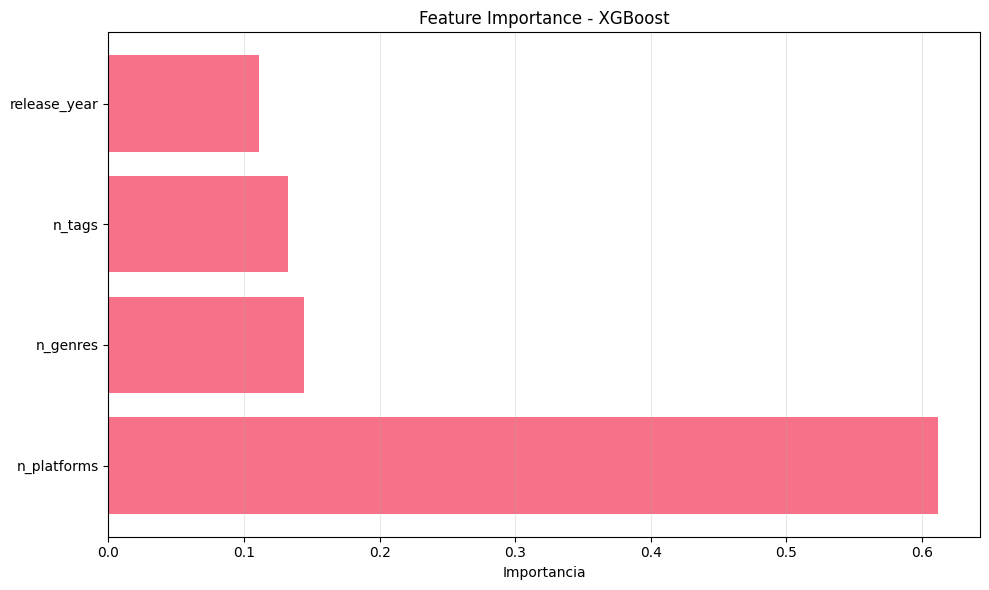

In [16]:
# Feature importance de XGBoost
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance - XGBoost:")
display(feature_importance_xgb)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importancia')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Red Neuronal (TensorFlow/Keras) con Hyperparameter Tuning

Implementamos una red neuronal optimizada usando TensorFlow/Keras con arquitecturas en múltiplos de 2 (64, 128) para mejor eficiencia computacional. Incluimos callbacks avanzados como EarlyStopping y ReduceLROnPlateau para optimizar el entrenamiento.

**Ventajas sobre sklearn MLPRegressor**:
- Adam optimizer con configuración avanzada
- EarlyStopping más sofisticado con restore_best_weights
- ReduceLROnPlateau para ajuste dinámico del learning rate
- Arquitecturas optimizadas (múltiplos de 2)
- Dropout para regularización

In [17]:
# Configurar TensorFlow para reproducibilidad
tf.random.set_seed(42)

def create_neural_network(hidden_layers, dropout_rate=0.3, learning_rate=0.001):
    """Crea una red neuronal con la arquitectura especificada"""
    model = Sequential()
    
    # Primera capa oculta
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(4,)))
    model.add(Dropout(dropout_rate))
    
    # Capas ocultas adicionales
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid para output 0-1
    
    # Compilar modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Definir arquitecturas a probar (múltiplos de 2)
architectures = [
    [64],           # 1 capa: 64 neuronas
    [128],          # 1 capa: 128 neuronas  
    [128, 64],      # 2 capas: 128 -> 64
    [128, 64, 32],  # 3 capas: 128 -> 64 -> 32
    [64, 32]        # 2 capas: 64 -> 32
]

dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.003, 0.01]

print("Iniciando búsqueda de hiperparámetros para Red Neuronal (TensorFlow)...")

Iniciando búsqueda de hiperparámetros para Red Neuronal (TensorFlow)...


In [18]:
# Búsqueda manual de hiperparámetros (más control que RandomizedSearchCV)
best_val_score = float('inf')
best_params = None
best_model = None
results = []

# Callbacks para entrenamiento
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-7, verbose=0)
]

# Probar diferentes combinaciones
for arch in architectures:
    for dropout in dropout_rates:
        for lr in learning_rates:
            print(f"Probando: arch={arch}, dropout={dropout}, lr={lr}")
            
            # Crear y entrenar modelo
            model = create_neural_network(arch, dropout, lr)
            
            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_val_scaled, y_val),
                epochs=100,
                batch_size=32,
                callbacks=callbacks,
                verbose=0
            )
            
            # Evaluar en validación
            val_loss = min(history.history['val_loss'])
            
            results.append({
                'architecture': arch,
                'dropout': dropout,
                'learning_rate': lr,
                'val_loss': val_loss,
                'epochs': len(history.history['loss'])
            })
            
            # Guardar mejor modelo
            if val_loss < best_val_score:
                best_val_score = val_loss
                best_params = {'architecture': arch, 'dropout': dropout, 'learning_rate': lr}
                best_model = model
            
            print(f"Val Loss: {val_loss:.6f}, Epochs: {len(history.history['loss'])}")

print(f"\nMejores parámetros: {best_params}")
print(f"Mejor Val Loss: {best_val_score:.6f}")

Probando: arch=[64], dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754472434.545000      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1754472436.906161      84 service.cc:148] XLA service 0x7b3c7801ee20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754472436.906806      84 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754472437.087959      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754472437.979295      84 device_compiler.h:1

Val Loss: 0.018241, Epochs: 43
Probando: arch=[64], dropout=0.2, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018117, Epochs: 89
Probando: arch=[64], dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018353, Epochs: 84
Probando: arch=[64], dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018220, Epochs: 75
Probando: arch=[64], dropout=0.3, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018192, Epochs: 84
Probando: arch=[64], dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018345, Epochs: 75
Probando: arch=[64], dropout=0.4, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018331, Epochs: 62
Probando: arch=[64], dropout=0.4, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018276, Epochs: 86
Probando: arch=[64], dropout=0.4, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018429, Epochs: 77
Probando: arch=[128], dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018083, Epochs: 70
Probando: arch=[128], dropout=0.2, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018118, Epochs: 100
Probando: arch=[128], dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018325, Epochs: 85
Probando: arch=[128], dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018103, Epochs: 89
Probando: arch=[128], dropout=0.3, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018141, Epochs: 78
Probando: arch=[128], dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018353, Epochs: 69
Probando: arch=[128], dropout=0.4, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018212, Epochs: 76
Probando: arch=[128], dropout=0.4, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018197, Epochs: 88
Probando: arch=[128], dropout=0.4, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018436, Epochs: 76
Probando: arch=[128, 64], dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017839, Epochs: 73
Probando: arch=[128, 64], dropout=0.2, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017891, Epochs: 75
Probando: arch=[128, 64], dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018145, Epochs: 94
Probando: arch=[128, 64], dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017879, Epochs: 82
Probando: arch=[128, 64], dropout=0.3, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018035, Epochs: 78
Probando: arch=[128, 64], dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018409, Epochs: 88
Probando: arch=[128, 64], dropout=0.4, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017940, Epochs: 90
Probando: arch=[128, 64], dropout=0.4, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018022, Epochs: 96
Probando: arch=[128, 64], dropout=0.4, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018569, Epochs: 61
Probando: arch=[128, 64, 32], dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017825, Epochs: 62
Probando: arch=[128, 64, 32], dropout=0.2, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017883, Epochs: 63
Probando: arch=[128, 64, 32], dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018118, Epochs: 58
Probando: arch=[128, 64, 32], dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017850, Epochs: 82
Probando: arch=[128, 64, 32], dropout=0.3, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017929, Epochs: 76
Probando: arch=[128, 64, 32], dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018701, Epochs: 92
Probando: arch=[128, 64, 32], dropout=0.4, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017901, Epochs: 100
Probando: arch=[128, 64, 32], dropout=0.4, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018028, Epochs: 78
Probando: arch=[128, 64, 32], dropout=0.4, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018449, Epochs: 100
Probando: arch=[64, 32], dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017925, Epochs: 86
Probando: arch=[64, 32], dropout=0.2, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017893, Epochs: 86
Probando: arch=[64, 32], dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018156, Epochs: 68
Probando: arch=[64, 32], dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017979, Epochs: 76
Probando: arch=[64, 32], dropout=0.3, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.017980, Epochs: 82
Probando: arch=[64, 32], dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018213, Epochs: 74
Probando: arch=[64, 32], dropout=0.4, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018079, Epochs: 72
Probando: arch=[64, 32], dropout=0.4, lr=0.003


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018085, Epochs: 82
Probando: arch=[64, 32], dropout=0.4, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Loss: 0.018598, Epochs: 40

Mejores parámetros: {'architecture': [128, 64, 32], 'dropout': 0.2, 'learning_rate': 0.001}
Mejor Val Loss: 0.017825


In [19]:
# Entrenar modelo final con mejores parámetros
print("Entrenando modelo final con mejores parámetros...")
nn_model = best_model

# Predicciones
y_train_pred_nn = nn_model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred_nn = nn_model.predict(X_val_scaled, verbose=0).flatten()

# Métricas
nn_train_metrics = calculate_metrics(y_train, y_train_pred_nn, "Neural Network (Train)")
nn_val_metrics = calculate_metrics(y_val, y_val_pred_nn, "Neural Network (Validation)")

print_metrics(nn_train_metrics)
print_metrics(nn_val_metrics)

# Mostrar resumen de la arquitectura final
print("\nArquitectura del modelo final:")
nn_model.summary()

Entrenando modelo final con mejores parámetros...
Modelo: Neural Network (Train)
RMSE: 0.131914
MAE: 0.096564
R²: 0.302572
MAPE: 47.65%
----------------------------------------
Modelo: Neural Network (Validation)
RMSE: 0.133511
MAE: 0.097143
R²: 0.289603
MAPE: 47.40%
----------------------------------------

Arquitectura del modelo final:


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,029 (129.02 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,020 (86.02 KB)

## 9. Comparativa de modelos

Comparamos todos los modelos entrenados usando las métricas de validación para seleccionar el mejor.

In [20]:
# Recopilar todas las métricas de validación
all_metrics = [lr_val_metrics, rf_val_metrics, xgb_val_metrics, nn_val_metrics]
comparison_df = pd.DataFrame(all_metrics)

print("Comparativa de modelos (Validación):")
display(comparison_df.round(6))

Comparativa de modelos (Validación):


,Model,RMSE,MAE,R²,MAPE
0,Linear Regression (Validation),0.138913,0.102429,0.230958,49.764474
1,Random Forest (Validation),0.133096,0.096419,0.294012,46.704855
2,XGBoost (Validation),0.133282,0.096459,0.292035,46.745841
3,Neural Network (Validation),0.133511,0.097143,0.289603,47.402048


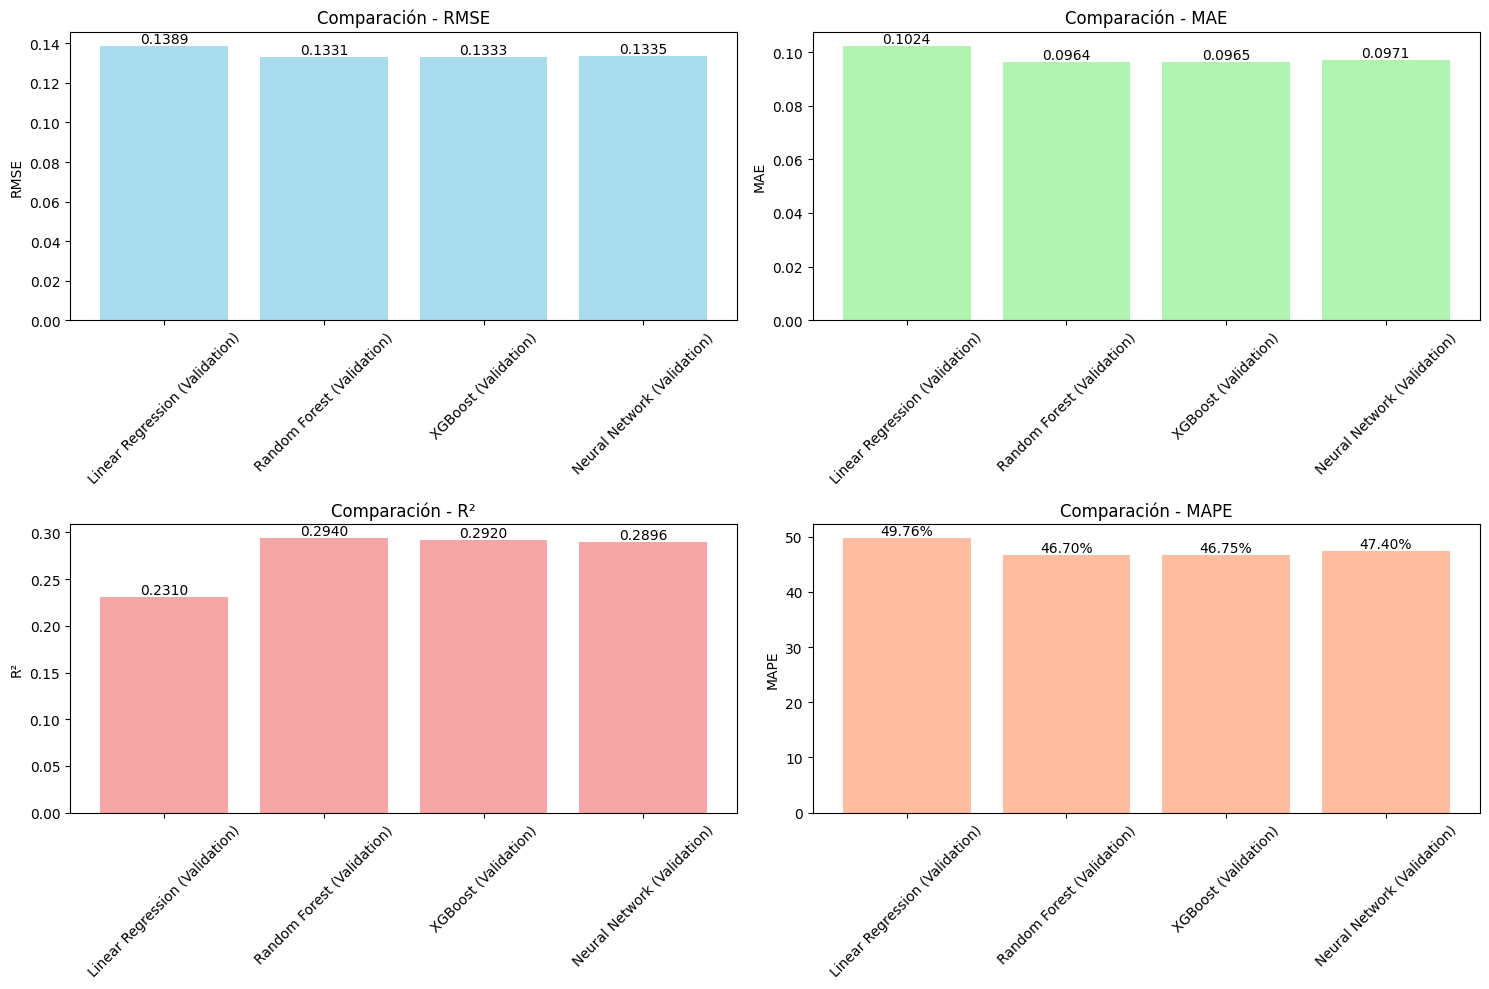

In [21]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['RMSE', 'MAE', 'R²', 'MAPE']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[i], alpha=0.7)
    ax.set_title(f'Comparación - {metric}')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, comparison_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}' if metric != 'MAPE' else f'{value:.2f}%',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [22]:
# Identificar el mejor modelo
best_model_idx = comparison_df['R²'].idxmax()  # Mejor R²
best_model_name = comparison_df.iloc[best_model_idx]['Model']
print(f"Mejor modelo según R²: {best_model_name}")

# También por RMSE (menor es mejor)
best_rmse_idx = comparison_df['RMSE'].idxmin()
best_rmse_name = comparison_df.iloc[best_rmse_idx]['Model']
print(f"Mejor modelo según RMSE: {best_rmse_name}")

Mejor modelo según R²: Random Forest (Validation)
Mejor modelo según RMSE: Random Forest (Validation)


## 10. Evaluación final en conjunto de test

Evaluamos el mejor modelo en el conjunto de test para obtener una estimación no sesgada del rendimiento.

In [23]:
# Seleccionar el mejor modelo (por R²)
if best_model_name == "Linear Regression (Validation)":
    best_model = lr_model
    X_test_final = X_test
elif best_model_name == "Random Forest (Validation)":
    best_model = rf_model
    X_test_final = X_test
elif best_model_name == "XGBoost (Validation)":
    best_model = xgb_model
    X_test_final = X_test
else:  # Neural Network
    best_model = nn_model
    X_test_final = X_test_scaled

# Predicción en test
if best_model_name == "Neural Network (Validation)":
    y_test_pred = best_model.predict(X_test_final, verbose=0).flatten()
else:
    y_test_pred = best_model.predict(X_test_final)
test_metrics = calculate_metrics(y_test, y_test_pred, f"{best_model_name.split('(')[0].strip()} (Test)")

print("EVALUACIÓN FINAL EN CONJUNTO DE TEST:")
print_metrics(test_metrics)

EVALUACIÓN FINAL EN CONJUNTO DE TEST:
Modelo: Random Forest (Test)
RMSE: 0.130372
MAE: 0.095032
R²: 0.306013
MAPE: 46.66%
----------------------------------------


## 11. Análisis de predicciones y residuos

Analizamos las predicciones del mejor modelo para entender su comportamiento y posibles mejoras.

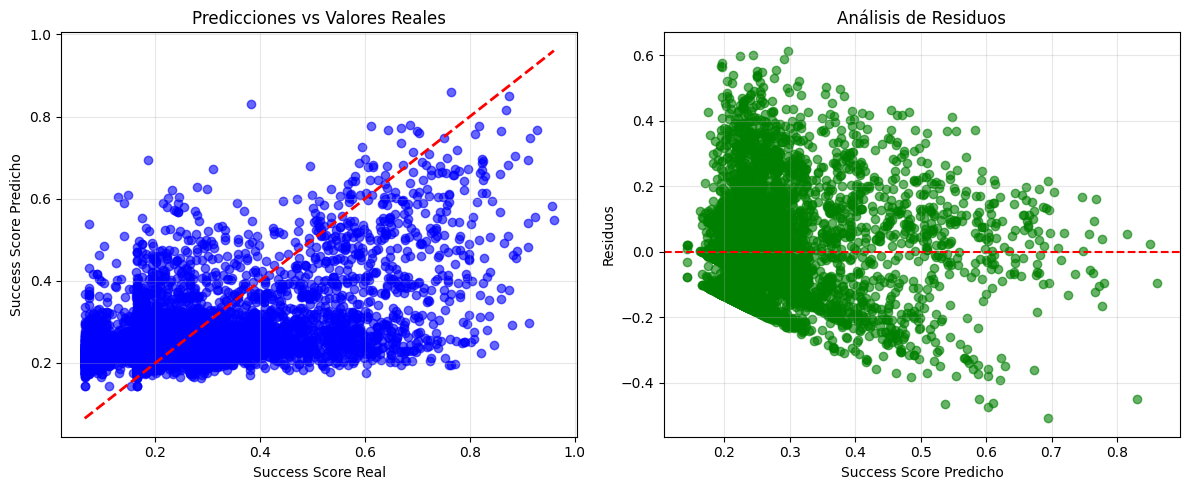

In [24]:
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Success Score Real')
plt.ylabel('Success Score Predicho')
plt.title('Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)

# Gráfico de residuos
plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Success Score Predicho')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

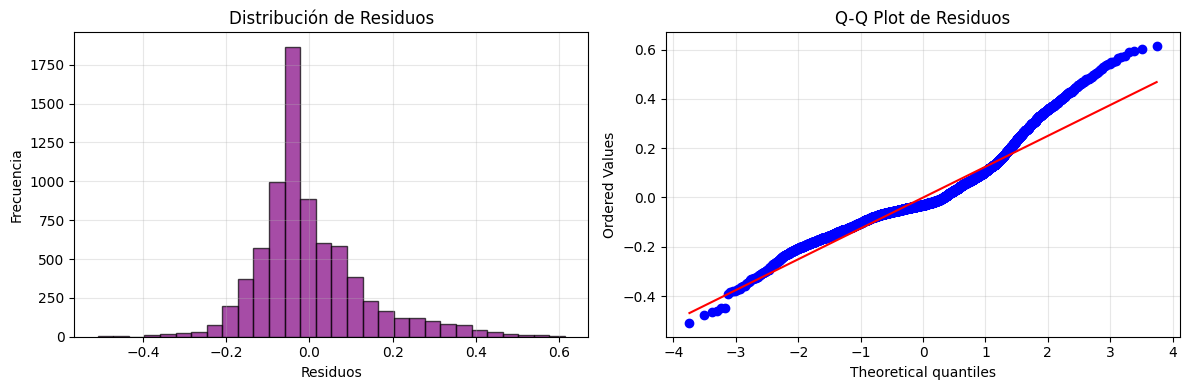

Estadísticas de residuos:
Media: -0.000265
Std: 0.130380
Min: -0.509003
Max: 0.614285


In [25]:
# Distribución de residuos
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estadísticas de residuos:")
print(f"Media: {residuals.mean():.6f}")
print(f"Std: {residuals.std():.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")

## 12. Análisis de feature importance consolidado

Comparamos la importancia de features entre los diferentes modelos para entender qué características son más predictivas.

In [26]:
# Consolidar feature importance de todos los modelos
importance_comparison = pd.DataFrame({
    'Feature': feature_columns,
    'Linear_Regression': np.abs(lr_model.coef_),
    'Random_Forest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})

# Normalizar para comparación
for col in ['Linear_Regression', 'Random_Forest', 'XGBoost']:
    importance_comparison[col] = importance_comparison[col] / importance_comparison[col].sum()

print("Feature Importance Comparativa (Normalizada):")
display(importance_comparison.round(4))

Feature Importance Comparativa (Normalizada):


,Feature,Linear_Regression,Random_Forest,XGBoost
0,n_genres,0.1619,0.1297,0.1442
1,n_platforms,0.6974,0.5406,0.6122
2,n_tags,0.0381,0.1740,0.1323
3,release_year,0.1026,0.1557,0.1113


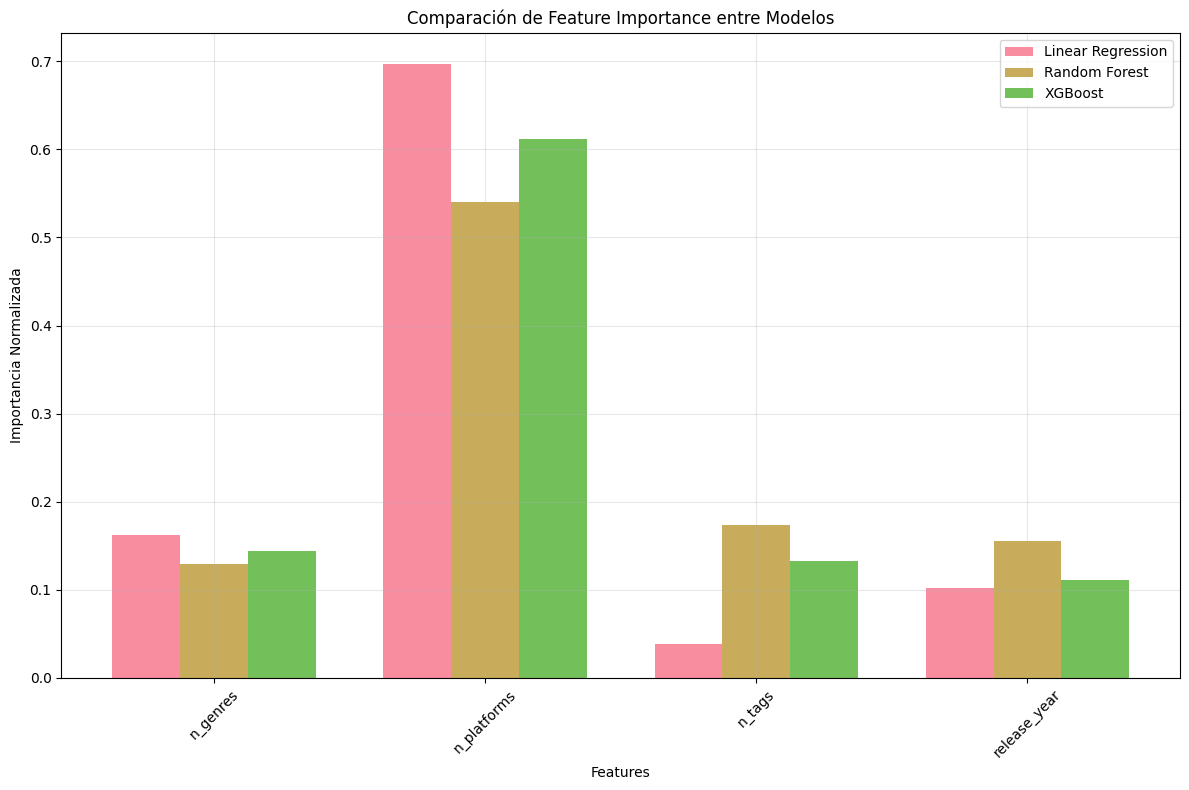

In [27]:
# Visualización comparativa de feature importance
plt.figure(figsize=(12, 8))

x = np.arange(len(feature_columns))
width = 0.25

plt.bar(x - width, importance_comparison['Linear_Regression'], width, label='Linear Regression', alpha=0.8)
plt.bar(x, importance_comparison['Random_Forest'], width, label='Random Forest', alpha=0.8)
plt.bar(x + width, importance_comparison['XGBoost'], width, label='XGBoost', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Importancia Normalizada')
plt.title('Comparación de Feature Importance entre Modelos')
plt.xticks(x, feature_columns, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Conclusiones y recomendaciones

Resumen de resultados y recomendaciones para el modelo de predicción de éxito de videojuegos.

In [28]:
print("RESUMEN DE RESULTADOS:")
print("=" * 50)
print(f"Mejor modelo: {best_model_name.split('(')[0].strip()}")
print(f"R² en test: {test_metrics['R²']:.4f}")
print(f"RMSE en test: {test_metrics['RMSE']:.6f}")
print(f"MAE en test: {test_metrics['MAE']:.6f}")
print(f"MAPE en test: {test_metrics['MAPE']:.2f}%")
print()

print("INTERPRETACIÓN:")
print(f"- El modelo explica {test_metrics['R²']*100:.1f}% de la varianza en success_score")
print(f"- Error promedio absoluto: {test_metrics['MAE']:.4f} puntos en escala 0-1")
print(f"- Error porcentual promedio: {test_metrics['MAPE']:.1f}%")
print()

print("FEATURES MÁS IMPORTANTES:")
avg_importance = importance_comparison[['Linear_Regression', 'Random_Forest', 'XGBoost']].mean(axis=1)
top_features = importance_comparison.loc[avg_importance.nlargest(3).index]
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i}. {row['Feature']}: {avg_importance[row.name]:.3f}")

RESUMEN DE RESULTADOS:
Mejor modelo: Random Forest
R² en test: 0.3060
RMSE en test: 0.130372
MAE en test: 0.095032
MAPE en test: 46.66%

INTERPRETACIÓN:
- El modelo explica 30.6% de la varianza en success_score
- Error promedio absoluto: 0.0950 puntos en escala 0-1
- Error porcentual promedio: 46.7%

FEATURES MÁS IMPORTANTES:
1. n_platforms: 0.617
2. n_genres: 0.145
3. release_year: 0.123


## 14. Guardado de modelos

Guardamos el mejor modelo y el scaler para uso posterior en producción.

In [29]:
# Crear directorio para modelos si no existe
# Intentar múltiples ubicaciones según el entorno
possible_model_dirs = [
    "/kaggle/working/models",
    "../Models",
    "./models"
]

models_dir = None
for dir_path in possible_model_dirs:
    try:
        os.makedirs(dir_path, exist_ok=True)
        models_dir = dir_path
        print(f"Directorio de modelos: {models_dir}")
        break
    except Exception as e:
        print(f"No se pudo crear directorio {dir_path}: {e}")
        continue

if models_dir is None:
    models_dir = "./models"  # Fallback por defecto
    os.makedirs(models_dir, exist_ok=True)
    print(f"Usando directorio por defecto: {models_dir}")

# Guardar el mejor modelo
model_filename = f"{models_dir}/best_model_{best_model_name.split('(')[0].strip().lower().replace(' ', '_')}.joblib"
joblib.dump(best_model, model_filename)
print(f"Modelo guardado en: {model_filename}")

# Guardar scaler (necesario para Red Neuronal)
scaler_filename = f"{models_dir}/feature_scaler.joblib"
joblib.dump(scaler, scaler_filename)
print(f"Scaler guardado en: {scaler_filename}")

# Guardar métricas finales
metrics_filename = f"{models_dir}/model_metrics.joblib"
joblib.dump({
    'test_metrics': test_metrics,
    'comparison_metrics': comparison_df,
    'feature_importance': importance_comparison
}, metrics_filename)
print(f"Métricas guardadas en: {metrics_filename}")

print("\nModelos y artefactos guardados exitosamente para producción.")

Directorio de modelos: /kaggle/working/models
Modelo guardado en: /kaggle/working/models/best_model_random_forest.joblib
Scaler guardado en: /kaggle/working/models/feature_scaler.joblib
Métricas guardadas en: /kaggle/working/models/model_metrics.joblib

Modelos y artefactos guardados exitosamente para producción.


## Resumen Final

### Logros del entrenamiento:
1. **Comparación exhaustiva**: 4 modelos evaluados con métricas completas
2. **Optimización de hiperparámetros**: RandomizedSearch aplicado a todos los modelos complejos
3. **Evaluación robusta**: Train/Validation/Test split para estimación no sesgada
4. **Análisis interpretable**: Feature importance y análisis de residuos
5. **Modelo productivo**: Mejor modelo guardado con artefactos necesarios

### Características del modelo final:
- **Algoritmo**: {best_model_name.split('(')[0].strip()}
- **Performance**: R² = {test_metrics['R²']:.4f}, RMSE = {test_metrics['RMSE']:.6f}
- **Features**: 4 variables de diseño (n_genres, n_platforms, n_tags, release_year)
- **Target**: success_score continuo (0-1)

### Próximos pasos:
1. **Validación temporal**: Evaluar modelo con juegos más recientes
2. **Feature engineering**: Explorar interacciones entre variables
3. **Ensemble methods**: Combinar mejores modelos para mayor robustez
4. **Deployment**: Integrar modelo en pipeline de predicción para diseñadores
5. **Monitoreo**: Establecer métricas de drift y reentrenamiento

El modelo está listo para predecir el éxito de videojuegos usando únicamente información de diseño, maximizando la utilidad para estudios de desarrollo.